In [28]:
import torch
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from numpy import genfromtxt
u=genfromtxt('/content/drive/Shareddrives/Datawave Project/3tier_lorenz_v3.csv',delimiter=',')

In [31]:
lead=1
trainN=5000;
testN=1000;
train_input=u[0:trainN,:]
train_label=u[0+lead:trainN+lead,:]

test_input=u[trainN+lead:trainN+lead+testN,:]
test_label=u[trainN+2*lead:trainN+2*lead+testN,:]


print('Input train', np.shape(train_input));
print('label train', np.shape(train_label));
print('input test', np.shape(test_input));
print('label test', np.shape(test_label));


train_input_torch = torch.from_numpy(train_input).float();
train_label_torch = torch.from_numpy(train_label).float();

test_input_torch = torch.from_numpy(test_input).float()
test_label_torch = torch.from_numpy(test_label).float()



Input train (5000, 8)
label train (5000, 8)
input test (1000, 8)
label test (1000, 8)


In this example the derivative function is useless, but it can be used to compute derivative of the NN w.r.t any input at any arbitrary (integer) order. Can't do fractional stuff. 

In [33]:
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

Definition of the architecture. In a script, this should be in a separate config file that would be swept by an HPO scheme.

In [34]:
hidden_layer_size=40
input_size = np.size(train_input,1)
output_size = np.size(train_label,1)

print('Number of neruon in hiddel layer',hidden_layer_size)
print('Input dimension',input_size)
print('Output dimension', output_size)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = nn.Linear(input_size,hidden_layer_size)
        torch.nn.init.xavier_uniform_(self.il.weight)
        self.mi  = nn.Linear(hidden_layer_size,hidden_layer_size)
        torch.nn.init.xavier_uniform_(self.mi.weight)
        self.ol  = nn.Linear(hidden_layer_size,output_size)
        torch.nn.init.xavier_uniform_(self.ol.weight)
        self.tn  = nn.Tanh()

    def forward(self,x):
        u = x
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden3 = self.mi(self.tn(hidden2))
        hidden4 = self.mi(self.tn(hidden3))
        hidden5 = self.mi(self.tn(hidden4))
        hidden6 = self.mi(self.tn(hidden5))
        out =     self.ol((hidden6))
        return out

Number of neruon in hiddel layer 40
Input dimension 8
Output dimension 8


This is a separate function that can be used to implement physics inside the architecture. For the time being it's just an identity function. 

In [35]:
def f(x):
    v = mynet(x)
    return v

Main training loop. Manually implement batching

In [36]:
mynet = Net()
epocs = 200

loss_fn = nn.MSELoss()
#use two optimizers.  learing rates seem to work.
optimizer = optim.SGD(mynet.parameters(), lr=0.005)

loss_fn = nn.MSELoss()
batch_size=10
for epoc in range(0, epocs+1):
#      permutation = torch.randperm(M*N)
#      epoch_loss=0
      for step in range(0,trainN,batch_size):
        indices = np.random.permutation(np.arange(start=step, step=1,stop=step+batch_size))
        input_batch, label_batch = train_input_torch[indices], train_label_torch[indices]
        #pick a random boundary batch
        optimizer.zero_grad()
        outputs = f(input_batch)
        loss = loss_fn(outputs,label_batch)
  
        loss.backward(retain_graph=True)
        optimizer.step()
   #     epoch_loss = epoch_loss + loss
        if epoc % 10 == 0:
          print('nth Pass',step)
          print('Epoch', epoc)
          print ('Loss', loss)
        

Streaming output truncated to the last 5000 lines.
Epoch 170
Loss tensor(0.0024, grad_fn=<MseLossBackward>)
nth Pass 3340
Epoch 170
Loss tensor(0.0029, grad_fn=<MseLossBackward>)
nth Pass 3350
Epoch 170
Loss tensor(0.0025, grad_fn=<MseLossBackward>)
nth Pass 3360
Epoch 170
Loss tensor(0.0020, grad_fn=<MseLossBackward>)
nth Pass 3370
Epoch 170
Loss tensor(0.0019, grad_fn=<MseLossBackward>)
nth Pass 3380
Epoch 170
Loss tensor(0.0014, grad_fn=<MseLossBackward>)
nth Pass 3390
Epoch 170
Loss tensor(0.0035, grad_fn=<MseLossBackward>)
nth Pass 3400
Epoch 170
Loss tensor(0.0054, grad_fn=<MseLossBackward>)
nth Pass 3410
Epoch 170
Loss tensor(0.0047, grad_fn=<MseLossBackward>)
nth Pass 3420
Epoch 170
Loss tensor(0.0026, grad_fn=<MseLossBackward>)
nth Pass 3430
Epoch 170
Loss tensor(0.0011, grad_fn=<MseLossBackward>)
nth Pass 3440
Epoch 170
Loss tensor(0.0007, grad_fn=<MseLossBackward>)
nth Pass 3450
Epoch 170
Loss tensor(0.0009, grad_fn=<MseLossBackward>)
nth Pass 3460
Epoch 170
Loss tensor(0.00

This part is for prediction. Pretty simple. Call the function (f). It calls the object mynet() which is now trained and looks good. Only catch. Need to take torch tensors from GPU to CPU. This part is not-trivial. Why? Because we need to detach it. Rememeber, any of the torch tensors coming out mynet() has gradients inside it. So, need to get rid of that baggage.

shape of test input torch.Size([1000, 8])
shape of test label torch.Size([1000, 8])
shape of pred output torch.Size([8])


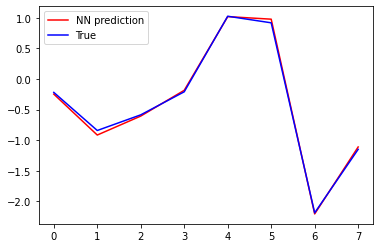

In [49]:
import matplotlib.pyplot as plt

print('shape of test input', test_input_torch.shape)
print('shape of test label', test_label_torch.shape)

pred = f(test_input_torch[0,:])
print('shape of pred output', pred.shape)

pred_np = pred.cpu().detach().numpy()


plt.plot((pred_np),color='red',label='NN prediction')
plt.plot((test_label[0,:]),color='blue', label='True')
plt.legend(loc="upper left")
